In [ ]:
!pip install tensorflow_decision_forests -U --quiet
!pip install wurlitzer -U --quiet

In [ ]:
import tensorflow_decision_forests as tfdf
import tensorflow as tf
import pandas as pd
from wurlitzer import sys_pipes
import matplotlib.pyplot as plt
import os
import numpy as np

# Access to advanced hyper-parameters. Part of "tensorflow_decision_forests".
from yggdrasil_decision_forests.learner.random_forest import random_forest_pb2
from yggdrasil_decision_forests.learner.decision_tree import decision_tree_pb2

In [56]:
def grid_coordinates(n:int, m:int):
  """Generates feature values following a grid pattern.
  
  If m=1, generates a 2d grid pattern of shape [n,n].
  If m>1, generates a 3d grid pattern of shape [n,n,m].
  """

  vs = np.linspace(-1, 1, n)
  if m > 1:
    ws = np.linspace(-1, 1, m)
    xs,ys,zs = np.meshgrid(vs,vs,ws)
    return np.stack([np.reshape(xs,[-1]), np.reshape(ys,[-1]), np.reshape(zs,[-1])], axis=1)
  else:
    xs,ys = np.meshgrid(vs,vs)
    return np.stack([np.reshape(xs,[-1]), np.reshape(ys,[-1])], axis=1)

grid_coordinates(2,2)

array([[-1., -1., -1.],
       [-1., -1.,  1.],
       [ 1., -1., -1.],
       [ 1., -1.,  1.],
       [-1.,  1., -1.],
       [-1.,  1.,  1.],
       [ 1.,  1., -1.],
       [ 1.,  1.,  1.]])

In [55]:
def random_coordinates(n: int, has_3d):
  """Generate random feature values.
  
  If has_3d, generates a 2d grid pattern of shape [n,n].
  If has_3d, generates a 3d grid pattern of shape [n,n,m].
  """

  np.random.seed(1234)
  if has_3d:
    return np.random.uniform(-1,1,size=[n,3])
  else:
    return np.random.uniform(-1,1,size=[n,2])

random_coordinates(3, True)

array([[-0.6169611 ,  0.24421754, -0.12454452],
       [ 0.57071717,  0.55995162, -0.45481479],
       [-0.44707149,  0.60374436,  0.91627871]])

In [58]:
def compute_labels(features):
  """Computes the labels."""
  
  if features.shape[1] == 2:
    scale = [1.0,1.5]
  else:
    scale = [1.0,1.5,1.5]
  return np.sqrt(np.sum(np.multiply(np.square(features),scale), axis=1)) <= 0.80

compute_labels(grid_coordinates(3,1))

array([False, False, False, False,  True, False, False, False, False])

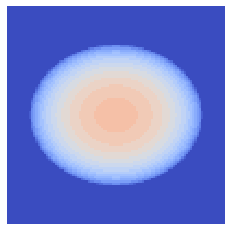

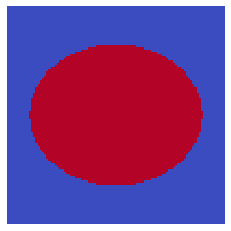

In [64]:
def plot_ellipse(labels, n:int, m:int,target):
  """Plots the labels/predictions from the grid-features."""
  
  if target is None:
    target = plt
  target.imshow(np.mean(np.reshape(labels,[n,n,m]),axis=2), interpolation="none", resample=False,  vmin=0.0, vmax=1.0,cmap="coolwarm")
  target.axis('off')

plot_ellipse(compute_labels(grid_coordinates(100, 50)), 100, 50, None)
plt.show()

plot_ellipse(compute_labels(grid_coordinates(100, 1)), 100, 1, None)
plt.show()

In [65]:
def train_model(model, n:int, has_3d):
  """Trains a model on "n" random examples."""
  
  train_features = random_coordinates(n, has_3d)
  train_labels = compute_labels(train_features)
  #with sys_pipes():
  model.fit(x=train_features, y=train_labels, verbose=0)
  return model

train_model(tfdf.keras.GradientBoostedTreesModel(), 1000, True)

In [68]:
def compute_predictions(model, n, m):
  """Compute the predictions of a model on a grid."""
  
  return model.predict(grid_coordinates(n, m))

compute_predictions(train_model(tfdf.keras.GradientBoostedTreesModel(), 10, False),2, 1)

array([[0.9076484 ],
       [0.63852715],
       [0.6385271 ],
       [0.24098207]], dtype=float32)

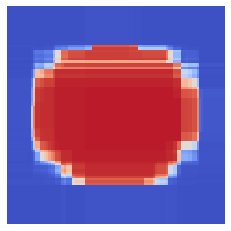

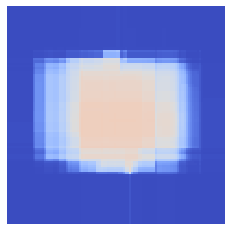

In [69]:
def train_and_plot_model(model, num_training:int, plot_resolution_n: int, plot_resolution_m: int, target):
  """Trains and plots the predictions of a model."""
  
  trained_model = train_model(model, num_training, plot_resolution_m>1)
  predictions = compute_predictions(trained_model, plot_resolution_n, plot_resolution_m)
  plot_ellipse(predictions, plot_resolution_n, plot_resolution_m,target)


train_and_plot_model(tfdf.keras.GradientBoostedTreesModel(), 1000, 100, 1, None)
plt.show()

train_and_plot_model(tfdf.keras.GradientBoostedTreesModel(), 1000, 100, 20, None)
plt.show()

Training examples: 10
Training examples: 20
Training examples: 50
Training examples: 100
Training examples: 1000
Training examples: 10000


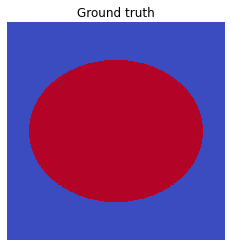

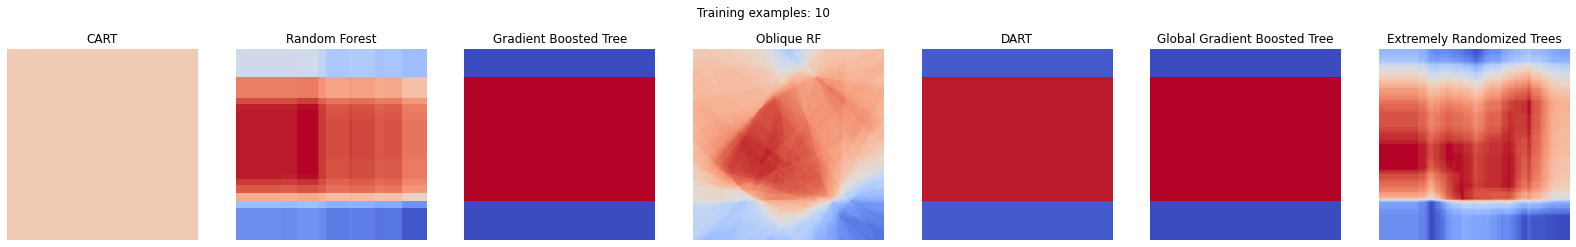

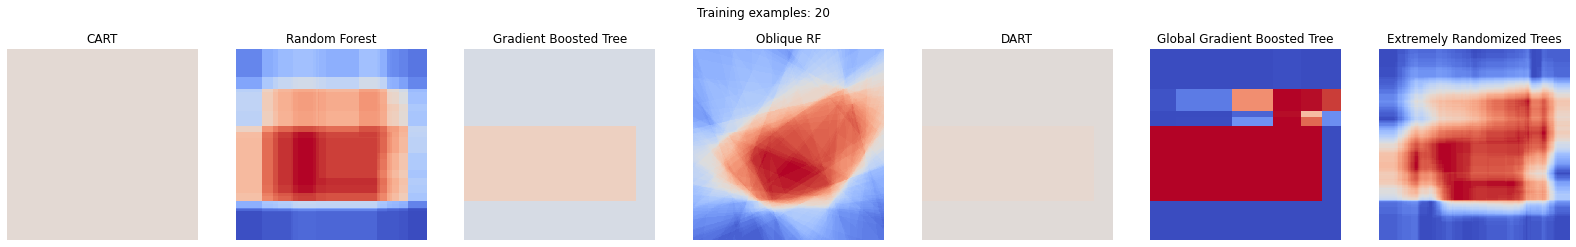

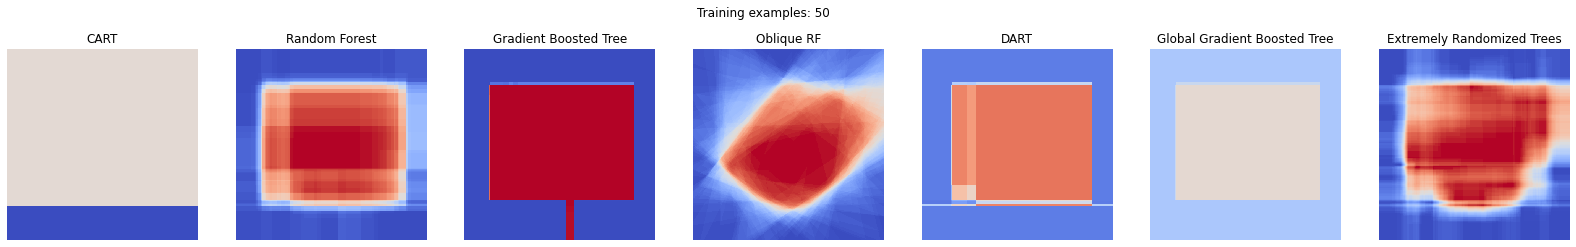

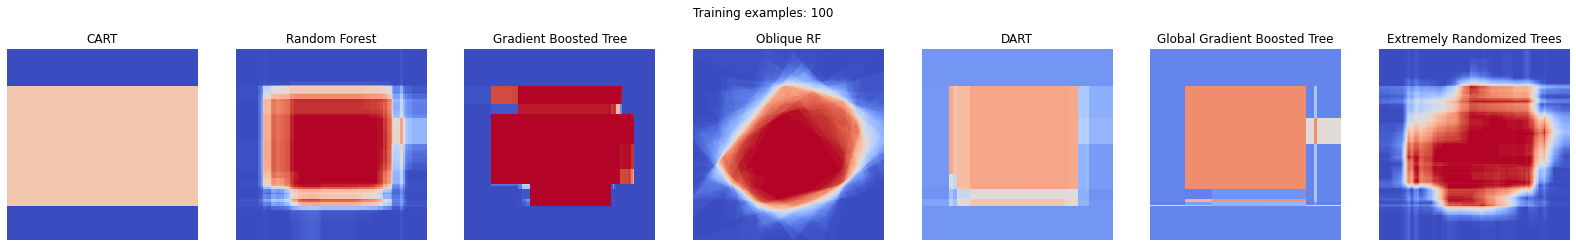

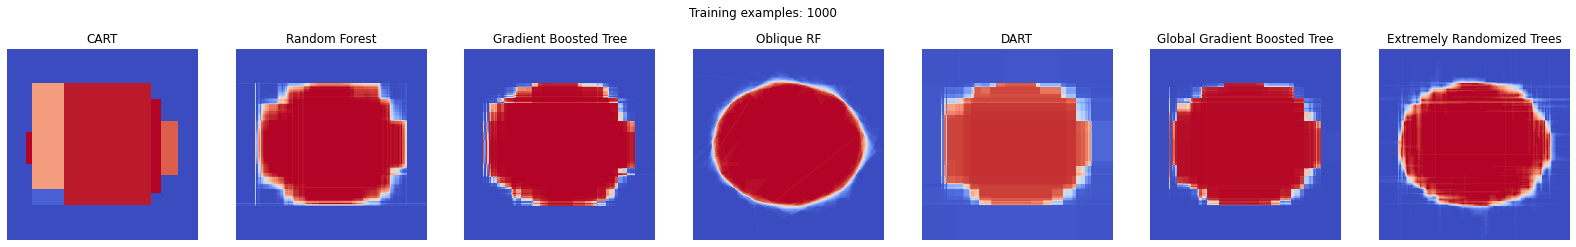

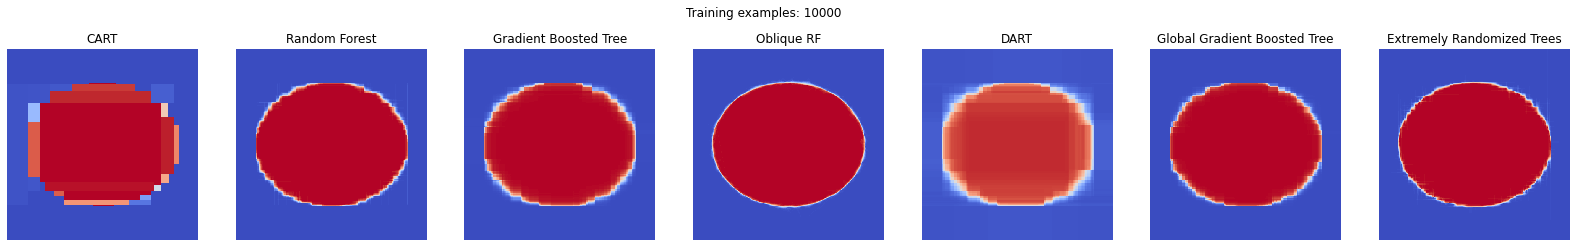

In [54]:
def plot_mozaik(n = 500, m = 1, list_num_examples=[10, 20, 50, 100, 1000, 10000]):
  """Trains and plots a collection of model."""
  
  cell_size = 4

  fig, axes = plt.subplots(1,1,figsize=(cell_size, cell_size))
  plot_ellipse(compute_labels(grid_coordinates(n, m)), n, m, axes)
  axes.set_title("Ground truth")
  fig.show()

  for num_examples in list_num_examples:

    print(f"Training examples: {num_examples}")

    num_candidates = 1+1*6
    fig, axes = plt.subplots(1,num_candidates,figsize=(cell_size * num_candidates,cell_size), squeeze=False)
    axes = [x for y in axes for x in y]
    plot_idx=0

    fig.suptitle(f"Training examples: {num_examples}")

    train_and_plot_model(tfdf.keras.CartModel(min_examples=1, max_depth=-1), num_examples, n, m, target=axes[plot_idx])
    axes[plot_idx].set_title(f"CART")
    plot_idx+=1

    for num_trees in [100]:

      train_and_plot_model(tfdf.keras.RandomForestModel(num_trees=num_trees, winner_take_all=False, min_examples=1, max_depth=-1), num_examples, n, m, target=axes[plot_idx])
      axes[plot_idx].set_title(f"Random Forest")
      plot_idx+=1

      train_and_plot_model(tfdf.keras.GradientBoostedTreesModel(num_trees=num_trees, min_examples=1), num_examples, n, m, target=axes[plot_idx])
      axes[plot_idx].set_title(f"Gradient Boosted Tree")
      plot_idx+=1

      yggdrasil_training_config = tfdf.keras.core.YggdrasilTrainingConfig()
      rf_training_config = yggdrasil_training_config.Extensions[random_forest_pb2.random_forest_config]
      rf_training_config.decision_tree.sparse_oblique_split.binary_weight = False
      model = tfdf.keras.RandomForestModel(num_trees=num_trees, winner_take_all=False, split_axis="SPARSE_OBLIQUE", min_examples=1, max_depth=-1,
                                           advanced_arguments=tfdf.keras.AdvancedArguments(yggdrasil_training_config=yggdrasil_training_config))
      train_and_plot_model(model, num_examples, n, m, target=axes[plot_idx])
      axes[plot_idx].set_title(f"Oblique RF")
      plot_idx+=1

      train_and_plot_model(tfdf.keras.GradientBoostedTreesModel(num_trees=num_trees, min_examples=1, forest_extraction="DART"), num_examples, n, m, target=axes[plot_idx])
      axes[plot_idx].set_title(f"DART")
      plot_idx+=1

      train_and_plot_model(tfdf.keras.GradientBoostedTreesModel(num_trees=num_trees, min_examples=1, growing_strategy="BEST_FIRST_GLOBAL"), num_examples, n, m, target=axes[plot_idx])
      axes[plot_idx].set_title(f"Global Gradient Boosted Tree")
      plot_idx+=1

      yggdrasil_training_config = tfdf.keras.core.YggdrasilTrainingConfig()
      rf_training_config = yggdrasil_training_config.Extensions[random_forest_pb2.random_forest_config]
      rf_training_config.bootstrap_training_dataset = False
      rf_training_config.decision_tree.numerical_split.type = decision_tree_pb2.NumericalSplit.HISTOGRAM_RANDOM
      model = tfdf.keras.RandomForestModel(num_trees=num_trees, winner_take_all=False, max_depth=-1, min_examples=1,
                                           advanced_arguments=tfdf.keras.AdvancedArguments(yggdrasil_training_config=yggdrasil_training_config))
      train_and_plot_model(model, num_examples, n, m, target=axes[plot_idx])
      axes[plot_idx].set_title(f"Extremely Randomized Trees")
      plot_idx+=1

    fig.show()

# Use "n=50" for a quick run (100x faster).
plot_mozaik(n = 500, m = 1, list_num_examples=[10, 20, 50, 100, 1000, 10000])